#### Imports

In [1]:
import os
import torch

# numpy is way faster than cupy - sticking with numpy for now
import numpy as cp

import scipy
import matplotlib.pyplot as plt
from scipy import signal


cp.random.seed(42)


#### ARMAX class

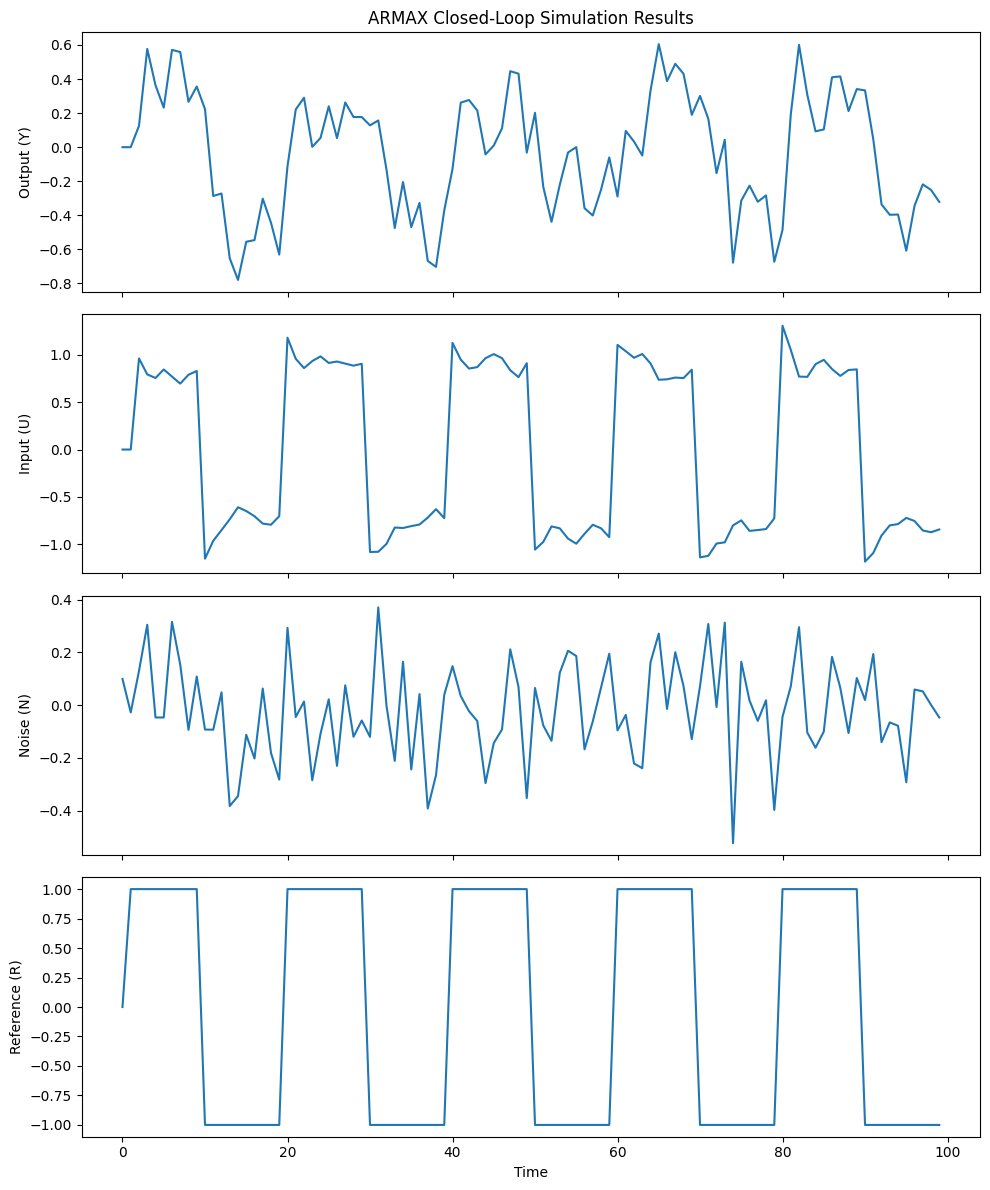

In [2]:
class ARMAX:
    def __init__(self, A, B, C, F, L):
        self.A = cp.array(A)
        self.B = cp.array(B)
        self.C = cp.array(C)
        self.F = cp.array(F)
        self.L = cp.array(L)
        # cp.random.seed(42)
    
    def simulate(self, n_samples, R=None, noise_std=0.1):
        Y = cp.zeros(n_samples)
        U = cp.zeros(n_samples)
        N = cp.random.normal(0, noise_std, n_samples)
        
        if R is None:
            R = cp.zeros(n_samples)
        
        max_order = max(len(self.A), len(self.B), len(self.C), len(self.F), len(self.L))
        
        for t in range(max_order, n_samples):
            Y[t] = (- cp.dot(self.A[1:], Y[t-1:t-len(self.A):-1]) 
                    + cp.dot(self.B, U[t-1:t-len(self.B)-1:-1])
                    + cp.dot(self.C, N[t:t-len(self.C):-1]))
            
            U[t] = (cp.dot(self.L, R[t:t-len(self.L):-1]) 
                    - cp.dot(self.F, Y[t:t-len(self.F):-1]))
        
        return Y, U, N, R
    
    def plot_results(self, Y, U, N, R):
        fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
        
        axs[0].plot(Y)
        axs[0].set_ylabel('Output (Y)')
        axs[0].set_title('ARMAX Closed-Loop Simulation Results')
        
        axs[1].plot(U)
        axs[1].set_ylabel('Input (U)')
        
        axs[2].plot(N)
        axs[2].set_ylabel('Noise (N)')
        
        axs[3].plot(R)
        axs[3].set_ylabel('Reference (R)')
        axs[3].set_xlabel('Time')
        
        plt.tight_layout()
        plt.show()

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ARMAX data gen example

A = [1, -0.33]  # A(z^-1) = 1 - 0.33z^-1
B = [0.22]      # B(z^-1) = 0.22z^-1
C = [1, 0.15]   # C(z^-1) = 1 + 0.15z^-1
F = [0.31, 0.23] # F(z^-1) = 0.31 + 0.23z^-1
L = [1]        # L(z^-1) = 1

armax_model = ARMAX(A, B, C, F, L)
n_samples = 100
# R = signal.square(cp.linspace(0, 10*cp.pi, n_samples)) # square wave reference signal
R = cp.sign(cp.sin(cp.linspace(0, 10*cp.pi, n_samples))) # square wave reference signal, works with both cupy and numpy

Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)
armax_model.plot_results(Y, U, N, R)


#### SPS indirect class

In [3]:
from sps_indirect import SPS_indirect_model

In [4]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SPS example

A  = [1, -0.33]
B = [0, 0.22]
C = [1, 0.15]

G = (B, A)  
H = (C, A)     
F = ([0.31, 0.23], [1])  
L = ([1], [1])         

m = 100
q = 5
T = n_samples  # Example sample size

# import cProfile, pstats
# profiler = cProfile.Profile()

model = SPS_indirect_model(m, q)
G_0, H_0 = model.transform_to_open_loop(G, H, F, L) # open loop system is Y_t = G_0(z^-1, kappa)U_t + H_0(z^-1, kappa)N_t
in_sps, S1 = model.open_loop_sps(G_0=G_0, H_0=H_0, Y_t=Y, U_t=R, n_a=1, n_b=1)

#### First order SPS

##### conf_region_1st_order()

In [5]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ example of identifying an SPS confidence region

def conf_region_1st_order(a_values, b_values, model, C, L, F, Y, R):

    # Create a meshgrid for a and b values
    a_grid, b_grid = cp.meshgrid(a_values, b_values, indexing='ij')

    # Flatten the grids for iteration
    a_flat = a_grid.ravel()
    b_flat = b_grid.ravel()

    # Store results in a list
    results = []

    # Create torch tensors directly on GPU
    try:
        _ = cp.asnumpy(C)
        device = torch.cuda.current_device()
    except:
        device = None
    a_torch = torch.tensor(a_flat, dtype=torch.float32, device=device)
    b_torch = torch.tensor(b_flat, dtype=torch.float32, device=device)

    # Vectorized operations to minimize Python loops
    A_torch = torch.stack([torch.ones_like(a_torch), -a_torch], dim=-1)
    B_torch = torch.stack([torch.zeros_like(b_torch), b_torch], dim=-1)
    # print(A_torch)

    # Perform the operations in batch
    A = cp.from_dlpack(A_torch)
    B = cp.from_dlpack(B_torch)

    # Assuming 'model' is predefined and contains the necessary methods
    for i in range(len(a_flat)):
        # print("A[i] = ", A[i], "            B[i] = ", B[i])
        G = (B[i], A[i])  # G should be a tuple of arrays
        H = (C, A[i])  # H should be a tuple of arrays

        # Transform to open loop
        G_0, H_0 = model.transform_to_open_loop(G, H, F, L)  # Assuming F and L are defined

        # Check the condition and store the result if true
        in_sps, S1 = model.open_loop_sps(G_0, H_0, Y, R, 1, 1)  # Assuming Y and U are defined
        if in_sps:
            results.append((a_flat[i].item(), b_flat[i].item()))
    # Convert the results to a NumPy array
    results = cp.array(results)
    return results

a_values = cp.arange(0, 1.0, 0.05)
b_values = cp.arange(0, 1.0, 0.05)
results = conf_region_1st_order(a_values, b_values, model, C, L, F, Y, R)

##### plot_results()

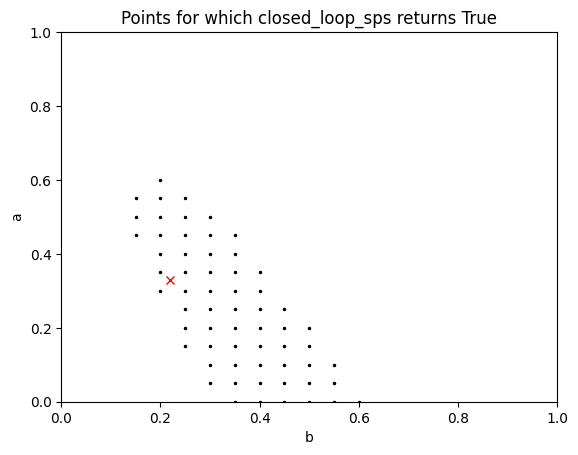

In [6]:
def plot_results(results, true_a=0.33, true_b=0.22, fig=None, ax=None):
    
    if fig is None and ax is None:
        fig, ax = plt.subplots()
        # labels
        ax.set_xlabel('b')
        ax.set_ylabel('a')
        # axis limits
        ax.set_xlim([0, 1.0])
        ax.set_ylim([0, 1.0])
        ax.set_title('Points for which closed_loop_sps returns True')
    elif fig is None and ax is not None:
        raise Exception("fig,ax must both be specified")
    elif fig is not None and ax is None:
        raise Exception("fig,ax must both be specified")
    
    try:
        results = cp.asnumpy(results)  # convert to np.ndarray
    except AttributeError:
        pass  # already an np.ndarray
    
    ax.plot(true_b, true_a, 'rx')  # Plot the true values as a red dot
    ax.plot(results[:, 1], results[:, 0], 'k.', markersize=3)

    # Show the plot
    # plt.show()

plot_results(results)

#### Optimal controls

##### tf_to_ocf()

In [7]:
from optimal_controls import tf_to_ocf, tf_list_to_ocf_list

c:\Users\conor\anaconda3\envs\capstone_v2\lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


In [8]:
tf_to_ocf([0, 0.5, 0.25], [2, 1, 0.5, 0.25])

(array([[ 0.   ,  0.   , -0.125],
        [ 1.   ,  0.   , -0.25 ],
        [ 0.   ,  1.   , -0.5  ]]),
 array([[0.   ],
        [0.125],
        [0.25 ]]),
 array([[0., 0., 1.]]))

In [9]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ example

# convert TF -> SS, using Observer Canonical Form (OCF)
identified_coeffs = [([0, 0.255, 0.58], [1, 0.45, 0.3, 0.2]),
                     ([0, 0.256, 0.56], [1, 0.43, 0.31, 0.23]),
                     ([0, 0.252, 0.52], [1, 0.44, 0.32, 0.25]),
                     ([0, 0.250, 0.58], [1, 0.41, 0.35, 0.19]),
                     ([0, 0.253, 0.53], [1, 0.42, 0.34, 0.21])]
A_in_set, B_in_set = tf_list_to_ocf_list(identified_coeffs)

##### get_optimal_controller()

In [10]:
from optimal_controls import get_optimal_controller

n = 3
Q = cp.eye(n)
R = cp.eye(1)
x_0 = cp.zeros([n,1])
x_0[0][0] = 1

get_optimal_controller(A_in_set,B_in_set,Q,R,x_0)

array([[ 0.69256098,  0.08651108, -0.21219427]])

In [11]:
# ~~~ some other 2x2 test matrices that can be used

# A_in_set = cp.array([
#         [[0.5, 1], [0, 0.25]], 
#         [[0.48, 1], [0, 0.25]],
#         [[0.52, 1], [0, 0.25]],
#         [[0.54, 1], [0, 0.25]]
#     ])

# B_in_set = cp.array([
#         [[0], [1]],
#         [[0], [1]],
#         [[0], [1]],
#         [[0], [1]]
#     ])

##### Speed tests

In [12]:
# from optimal_controls import get_optimal_controller_v_version1
# from optimal_controls import get_optimal_controller_v_version2

In [13]:
# for i in range(1000):
#     get_optimal_controller_v_version1(A_in_set,B_in_set,Q,R,x_0)
# get_optimal_controller_v_version1(A_in_set,B_in_set,Q,R,x_0)

In [14]:
# for i in range(1000):
#     get_optimal_controller_v_version2(A_in_set,B_in_set,Q,R,x_0)
# get_optimal_controller_v_version2(A_in_set,B_in_set,Q,R,x_0)

In [15]:
# from optimal_controls import dlqr, dlqr_custom
# A = A_in_set[0,:]
# B = B_in_set[0,:]

In [16]:
# for i in range(10000):
#     K, _ = dlqr(A, B, Q, R)

In [17]:
# for i in range(10000):
#     K, _ = dlqr_custom(A,B,Q,R,tol=1e-6)

##### get_optimal_controller() w/ SPS

In [18]:
k = 0.22 # initial feedback controller

k_vals = []
MSE_vals = []
points_in_conf_region_vals = []
a_vals = []

n_iters = 20
param_change_iter = 5

for i in range(n_iters):
# for i in range(11):

    if i >= param_change_iter:
        a = 0.3
    else:
        a = 0.6
    # a = 0.3  + 0.3*(i/n_iters)

    # ~~~~~~~~~~~ run the system, gather input/output data

    # n_samples = 100 + 100*i
    n_samples = 200
    m = 20
    q = 1

    A = [1, -a]      # A(z^-1) = 1 - az^-1
    B = [0.22]          # B(z^-1) = 0.22z^-1
    C = [1, 0.15]       # C(z^-1) = 1 + 0.15z^-1
    F = [k]             # proportional feedback
    L = [1]             # L(z^-1) = 1

    armax_model = ARMAX(A, B, C, F, L)
    
    # if i==0:
    #     R = cp.sign(cp.sin(cp.linspace(0, 10*cp.pi, n_samples)))
    # elif i==1:
    #     # impulse train (approximate, R=epsilon instead of R=0)
    #     R = cp.ones(n_samples) * 1e-6
    #     R[::50] = 1
    # elif i==2:
    #     R = signal.sawtooth(cp.linspace(0, 10*cp.pi, n_samples),width=0)
    # elif i==3:
    #     R = signal.sawtooth(cp.linspace(0, 10*cp.pi, n_samples),width=0)*0.5 + cp.ones(n_samples)*0.5
    # elif i==4:
    #     R = cp.ones(n_samples) * 0.01
    #     R = R ** cp.arange(n_samples)
    # elif i==5:
    #     R = cp.ones(n_samples) * 0.01
    #     R = R ** cp.arange(n_samples)
    # elif i==6:
    #     R = cp.ones(n_samples) * 0.5
    #     R = R ** cp.arange(n_samples)
    # elif i==7:
    #     R = cp.ones(n_samples) * 0.9
    #     R = R ** cp.arange(n_samples)
    # elif i==8:
    #     R = cp.ones(n_samples) * 0.98
    #     R = R ** cp.arange(n_samples)
    # elif i==9:
    #     R = cp.random.randn(n_samples) * 0.0001**2
    # elif i==10:
    #     R = signal.chirp(cp.linspace(0,10,n_samples),f0=0,t1=10*cp.pi,f1=5)

    if i % 2 == 0:
        # square wave
        R = cp.sign(cp.sin(cp.linspace(0, 10*cp.pi, n_samples)))
    else:
        # square wave
        R = cp.sign(cp.sin(cp.linspace(0, 10*cp.pi, n_samples)))
        
        # # impulse train (approximate, R=epsilon instead of R=0)
        # R = cp.ones(n_samples) * 1e-2
        # R[::50] = 1

        # # sawtooth
        # R = signal.sawtooth(cp.linspace(0, 10*cp.pi, n_samples),width=0) + cp.ones(n_samples)

        # exponentially decaying sequence
        # R = cp.ones(n_samples) * 0.9
        # R = R ** cp.arange(n_samples)
        # print('non-square input')


    Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)
    MSE = cp.sum((R - Y) ** 2) / n_samples
    MSE_vals.append(MSE)
    # armax_model.plot_results(Y,U,N,R)

    # ~~~~~~~~~~~ create the SPS model object with the current feedback controller

    model = SPS_indirect_model(m, q, n_samples-1)
    # print(model.N)

    A  = [1, -a]
    B = [0, 0.22]
    C = [1, 0.15]

    G = (B, A)  
    H = (C, A)     
    F = ([k], [1])
    L = ([1], [1])         

    G_0, H_0 = model.transform_to_open_loop(G, H, F, L) # open loop system is Y_t = G_0(z^-1, kappa)U_t + H_0(z^-1, kappa)N_t


    # ~~~~~~~~~~~ identify SPS confidence region using indirect SPS

    a_values = cp.arange(0, 1.0, 0.05)
    b_values = cp.arange(0, 0.5, 0.05)
    points_in_conf_region = conf_region_1st_order(a_values, b_values, model, C, L, F, Y, R)
    a_in_set = points_in_conf_region[:,0]
    b_in_set = points_in_conf_region[:,1]

    # ~~~~~~~~~~~ identify the optimal controller

    # A_ss, B_ss, C_ss, D_ss = signal.tf2ss(G[0], G[1]) # change the system representation (transfer function -> state space). NB: ignoring H(z)
    # a_in_set, b_in_set = tf_list_to_ocf_list(cp.array(list(zip(a_values, b_values))))
    k = get_optimal_controller(a_in_set,b_in_set,1,1) # solve the min-max problem - the minimisation is done by solving the DARE, maximisation by brute force (iterate over points in SPS confidence region)
    k_vals.append(k)
    points_in_conf_region_vals.append(points_in_conf_region)
    a_vals.append(a)
    
    # print("This run's mean squared error (MSE):", MSE)
    # print("New optimal controller:", k)
    # print(i)
    # plot_results(points_in_conf_region, true_a=a, true_b=0.22)


#### Fusion

##### construct_p_matrix()

In [19]:
def construct_p_matrix(points_in_conf_region, a_range, b_range, p=0.95, eps=1e-6):
    a_grid, b_grid = cp.meshgrid(a_range, b_range, indexing='ij')
    n_a = len(a_range)
    n_b = len(b_range)
    p_matrix = cp.ones((n_a,n_b)) * (1-p)
    for i in range(n_a):
        for j in range(n_b):
            a = a_grid[i][j]
            b = b_grid[i][j]
            # Check if the current gridpoint (a, b) is in the confidence region, update p_matrix if so
            if cp.any(cp.all(cp.isclose(points_in_conf_region, cp.array([a, b]), atol=eps), axis=1)):
                p_matrix[i][j] = p
    p_matrix /= cp.sum(cp.abs(p_matrix)) # normalise
    return p_matrix.copy()

 ##### plot_fused_conf_region()

In [20]:
import matplotlib.colors as colors

def plot_fused_conf_region(p_matrix, fig, ax, a_values, b_values, true_a=None, true_b=None, title=None):
    # a_offset = (a_values[1] - a_values[0]) * 0.5
    # b_offset = (b_values[1] - b_values[0]) * 0.5
    a_offset = 0
    b_offset = 0
    
    # PuBu_r
    # Greys
    im = ax.imshow(p_matrix, cmap="PuBu_r", origin="lower", norm=colors.LogNorm(vmin=1e-5, vmax=1e-1), extent=[b_values[0] - b_offset, b_values[-1]- b_offset, a_values[0]- a_offset, a_values[-1]- a_offset])
    ax.set_aspect('auto')
    ax.set_xticks(b_values[::10])
    ax.set_yticks(a_values[::10])
    ax.set_xlabel('b')
    ax.set_ylabel('a')
    fig.colorbar(im, ax=ax)
    if true_a is not None and true_b is not None:
        ax.plot(true_b, true_a, 'rx')  # Plot the true values as a red dot
    ax.set_title(title)


##### fuse()

In [21]:
def fuse(new_info, prior, forget=0):
    # https://en.wikipedia.org/wiki/Recursive_Bayesian_estimation#Model
    #  - not sure how to theoretically justify the forgetting factor part

    # forget: forgetting factor such that
    #   1 = disregard all past data
    #   0 = assume past data is always relevant (no change in plant over time)
    
    n_a = prior.shape[0]
    n_b = prior.shape[1]
    modified_prior = cp.mean(prior) * cp.ones(prior.shape) * forget + prior * (1-forget)
    posterior = cp.multiply(modified_prior, new_info) # Hadamard product
    posterior /= cp.sum(cp.abs(posterior)) # normalisation
    posterior = cp.maximum(1e-8, posterior) # to avoid floating point error, this is the new "zero" value
    return posterior

##### Example: performing fusion on previous SPS run's confidence regions

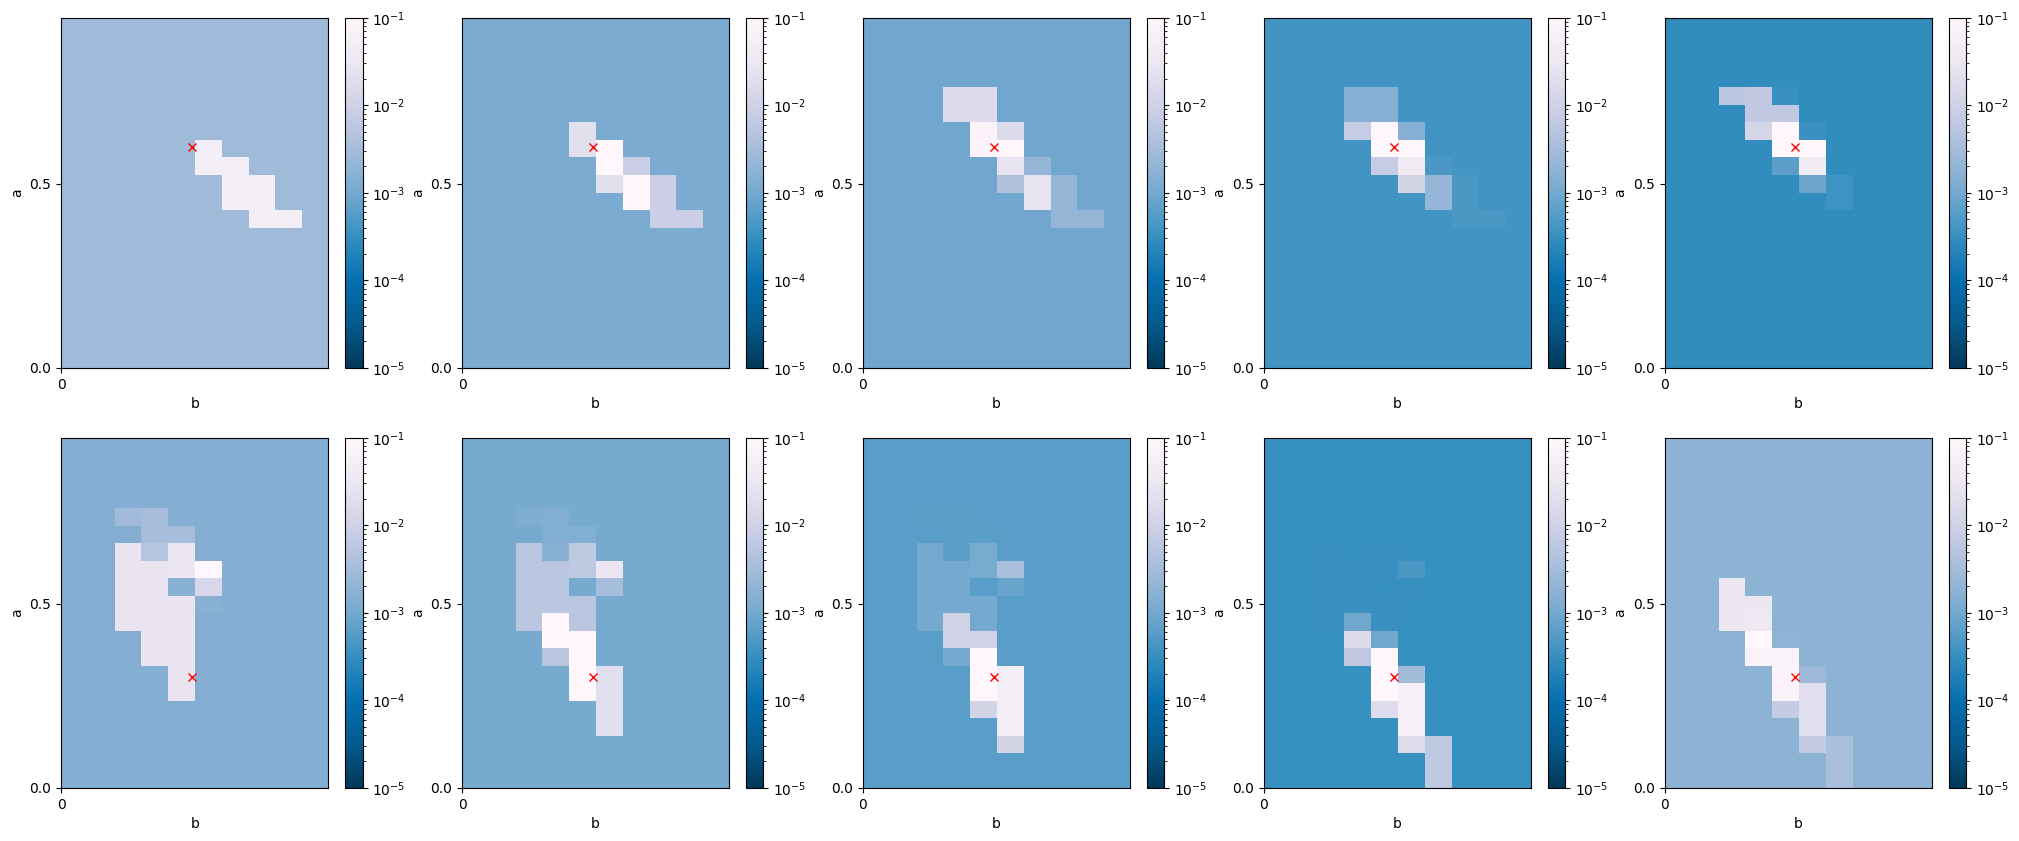

In [22]:
# ~~~~~~~~~~ generalised fusion

# set up the grid of plots
n_plots = 10
n_cols = 5
n_rows = int(cp.ceil(n_plots / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
axes = axes.flatten()

# initial confidence region comes from the first SPS run
prior_0 = construct_p_matrix(points_in_conf_region_vals[0], a_values, b_values, p=1-q/m)
plot_fused_conf_region(prior_0, fig, axes[0], a_values, b_values, true_a=a_vals[0], true_b=0.22)

# calculate and plot the fused confidence regions from each SPS run
for idx in range(1,n_plots):
    if idx == 1:
        prior = prior_0
    else:
        # posterior from last iteration is this iteration's prior
        prior = posterior

    # fuse the new info with the prior
    new_info = construct_p_matrix(points_in_conf_region_vals[idx], a_values, b_values, p=1-q/m)
    posterior = fuse(new_info, prior, forget=0.5)
    plot_fused_conf_region(posterior, fig, axes[idx], a_values, b_values, true_a=a_vals[idx], true_b=0.22)

##### sample_fused_conf_region()
This is an open problem - post-fusion, how do we find the (a,b) s.t. we have a 95% confidence region. One algorithm demonstrated below.

In [23]:
def sample_fused_conf_region(p_matrix,a_range,b_range,cumprob=0.95):
    """
    Find the 95% confidence region (a,b) points, given non-binary indicators.
    """

    # sort points by probability, storing the original indices so we can undo the mapping later
    flat_p_matrix = p_matrix.flatten()
    sorted_indices = cp.argsort(flat_p_matrix)[::-1]  # sort from highest to lowest probability
    sorted_probs = flat_p_matrix[sorted_indices]
    
    # find the threshold which gives set of plants that has approximately 0.95 cumulative probability
    candidate_thresholds = cp.sort(cp.unique(sorted_probs))[::-1]
    cumsums = []
    for threshold in candidate_thresholds:
        above_threshold = cp.where(sorted_probs >= threshold)
        cumsum = cp.cumsum(sorted_probs[above_threshold])[-1]
        cumsums.append(cumsum)
    cumsums = cp.array(cumsums)
    idx = cp.argmin(cp.abs(cumsums - cumprob))
    if idx == len(cumsums) - 1:
        idx -= 1
    threshold = candidate_thresholds[idx]
    p = cumsums[idx]

    # apply this threshold and return the corresponding set of plants
    top_indices = cp.where(sorted_probs >= threshold)[0]
    in_set = sorted_indices[top_indices]
    grid_positions = cp.unravel_index(in_set, p_matrix.shape)
    selected_points = list(zip(grid_positions[0], grid_positions[1]))
    a_grid, b_grid = cp.meshgrid(a_values, b_values, indexing='ij')
    a_selected = a_grid[grid_positions]
    b_selected = b_grid[grid_positions]

    return a_selected, b_selected, p

In [24]:
def sample_fused_conf_region_v0(p_matrix,a_range,b_range,cumprob=0.95):
    """
    Find the 95% confidence region (a,b) points, given non-binary indicators.
    """

    flat_p_matrix = p_matrix.flatten()
    sorted_indices = cp.argsort(flat_p_matrix)[::-1]  # Indices sorted from highest to lowest probability
    sorted_probs = flat_p_matrix[sorted_indices]
    eps = 1e-8
    

    # Compute cumulative sum
    cumulative_probs = cp.cumsum(sorted_probs)
    cutoff_index = cp.searchsorted(cumulative_probs, cumprob) # Find index where sum reaches 95%
    # Check for any equal probability values (equal := within epsilon of each other) around the cutoff and trim the array accordingly
    while cutoff_index > 0 and cp.abs(sorted_probs[cutoff_index + 0] - sorted_probs[cutoff_index - 1]) < eps:
        # the tolerance for epsilon-equals, is chosen to be roughly 3 significant digits
        eps = sorted_probs[cutoff_index] * 1e-3
        cutoff_index -= 1
    # ... but if we get back to the start of the list, scratch that idea
    if cutoff_index == 0:
        cutoff_index = cp.searchsorted(cumulative_probs, cumprob)  # Find index where sum reaches 95%
        print("[warning]")
    p = cumulative_probs[cutoff_index]

    # Get the selected grid indices
    top_indices = sorted_indices[:cutoff_index]
    grid_positions = cp.unravel_index(top_indices, p_matrix.shape)

    # Print the selected grid points
    selected_points = list(zip(grid_positions[0], grid_positions[1]))
    # print("95% confidence region grid indices:", selected_points)

    a_grid, b_grid = cp.meshgrid(a_range, b_range, indexing='ij')
    a_selected = a_grid[grid_positions]
    b_selected = b_grid[grid_positions]
    selected_ab_pairs = list(zip(a_selected, b_selected)) # Combine into (a, b) pairs
    # print("95% confidence region (a, b) values:", selected_ab_pairs)

    return a_selected, b_selected, p


#### Optimal control w/ fusion

##### Run plant + SPS + fusion

In [31]:
# use fusion at each iteration to get the confidence-region-so-far, and run min-max optimisation with this confidence region

k = 0.22 # initial feedback controller

k_vals = []
MSE_vals = []
points_in_conf_region_vals = []
sampled_conf_region_vals = []
a_vals = []
p_vals = []
posterior_vals = []

n_iters = 16
param_change_iter = 4

for i in range(n_iters):

    # ~~~~~~~~~~~ change a system parameter halfway through, to see how the algorithm adapts to change
    if i >= param_change_iter:
        a = 0.6
    else:
        a = 0.3
    b = 0.22

    # ~~~~~~~~~~~ run the system, gather input/output data
    n_samples = 200
    m = 20
    q = 1

    A = [1, -a]             # A(z^-1) = 1 - az^-1
    B = [b]                 # B(z^-1) = 0.22z^-1
    C = [1, 0.15]           # C(z^-1) = 1 + 0.15z^-1
    F = [k]                 # proportional feedback
    
    L = [1]               # L(z^-1) = 1
    # L = [k]

    # ff_gain = (1-a+b*k) / b # <<< this gives asymptotic reference tracking, but it's cheating
    # L = [ff_gain]           
                            # in practice the feedforward gain needs to be solved for using the identified plant parameters
                            # , or integrators added to the loop so this isn't needed

    armax_model = ARMAX(A, B, C, F, L)
    R = cp.sign(cp.sin(cp.linspace(0, 10*cp.pi, n_samples))) # square wave
    Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)
    MSE = (1 * cp.sum((R - Y) ** 2) + 1 * cp.sum(U ** 2) ) / n_samples
    MSE_vals.append(MSE)
    # armax_model.plot_results(Y,U,N,R)


    # ~~~~~~~~~~~ create the SPS model object with the current feedback controller

    model = SPS_indirect_model(m, q, n_samples-1)

    A  = [1, -a]
    B = [0, b]
    C = [1, 0.15]

    G = (B, A)  
    H = (C, A)     
    F = ([k], [1])
    L = ([1], [1])
    # L = ([k], [1])
    # L = ([ff_gain], [1])    # <<< this is cheating

    G_0, H_0 = model.transform_to_open_loop(G, H, F, L) # open loop system is Y_t = G_0(z^-1, kappa)U_t + H_0(z^-1, kappa)N_t


    # ~~~~~~~~~~~ identify SPS confidence region using indirect SPS

    a_values = cp.arange(0, 1.0, 0.02)
    b_values = cp.arange(0, 1.0, 0.02)
    points_in_conf_region = conf_region_1st_order(a_values, b_values, model, C, L, F, Y, R)
    a_in_set = points_in_conf_region[:,0]
    b_in_set = points_in_conf_region[:,1]


    # ~~~~~~~~~~~ fuse this run's SPS confidence region with previous ones

    if i == 0:
        posterior = construct_p_matrix(points_in_conf_region, a_values, b_values, p=1-q/m)
    else:
        # posterior from last iteration is this iteration's prior
        prior = posterior

        # fuse the new info with the prior
        new_info = construct_p_matrix(points_in_conf_region, a_values, b_values, p=1-q/m)
        posterior = fuse(new_info, prior, forget=0.0)


    # ~~~~~~~~~~~ identify the optimal controller
    
    a_in_set, b_in_set, p = sample_fused_conf_region(posterior,a_values,b_values,cumprob=1-q/m)
    assert(len(a_in_set) > 0)
    k = get_optimal_controller(a_in_set,b_in_set,1,1)
    k_vals.append(k)
    a_vals.append(a)
    p_vals.append(p)
    points_in_conf_region_vals.append(points_in_conf_region)
    posterior_vals.append(posterior)
    sampled_conf_region_vals.append(cp.array([a_in_set, b_in_set]).T)
    
    # print("This run's mean squared error (MSE):", MSE)
    # print("New optimal controller:", k)

In [26]:
# fig, axes = plt.subplots()
# axes.plot(MSE_vals)
# plt.show()

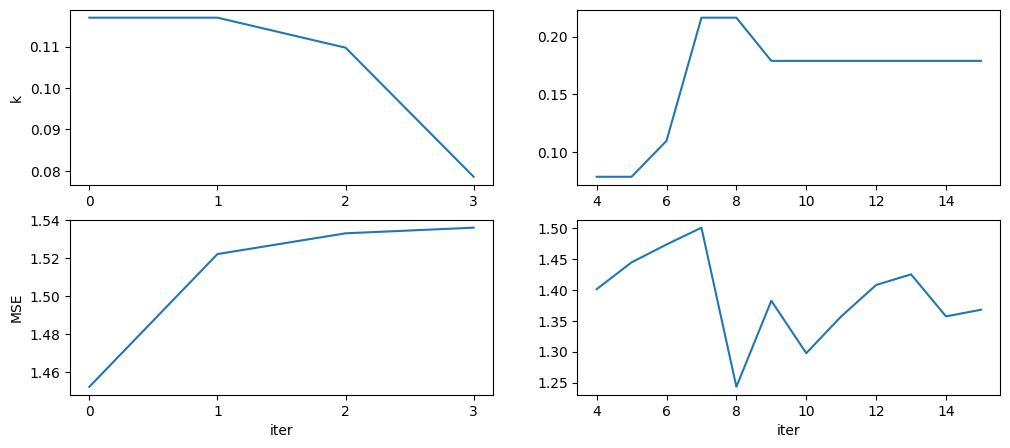

In [32]:
fig, axes = plt.subplots(2,2,figsize=(12,5))
axes = axes.flatten()
i1 = param_change_iter
i2 = n_iters

axes[0].plot(range(0,i1), k_vals[:i1])
axes[0].set_xticks(range(0,i1))

axes[1].plot(range(i1,i2), k_vals[i1:i2])

axes[2].plot(range(0,i1), MSE_vals[:i1])
axes[2].set_xticks(range(0,i1))

axes[3].plot(range(i1,i2), MSE_vals[i1:i2])

axes[0].set_ylabel('k')
axes[2].set_ylabel('MSE')
axes[2].set_xlabel('iter')
axes[3].set_xlabel('iter')

plt.show()

In [33]:
# NB: the control structure is not set up for reference tracking, hence MSE is not improving
#       - L(z) = 1, this is unity gain
#       - L(z) needs to be some constant (feedforward gain) calculated from (a,b,k)

##### demonstrate sample_fused_conf_region works as intended

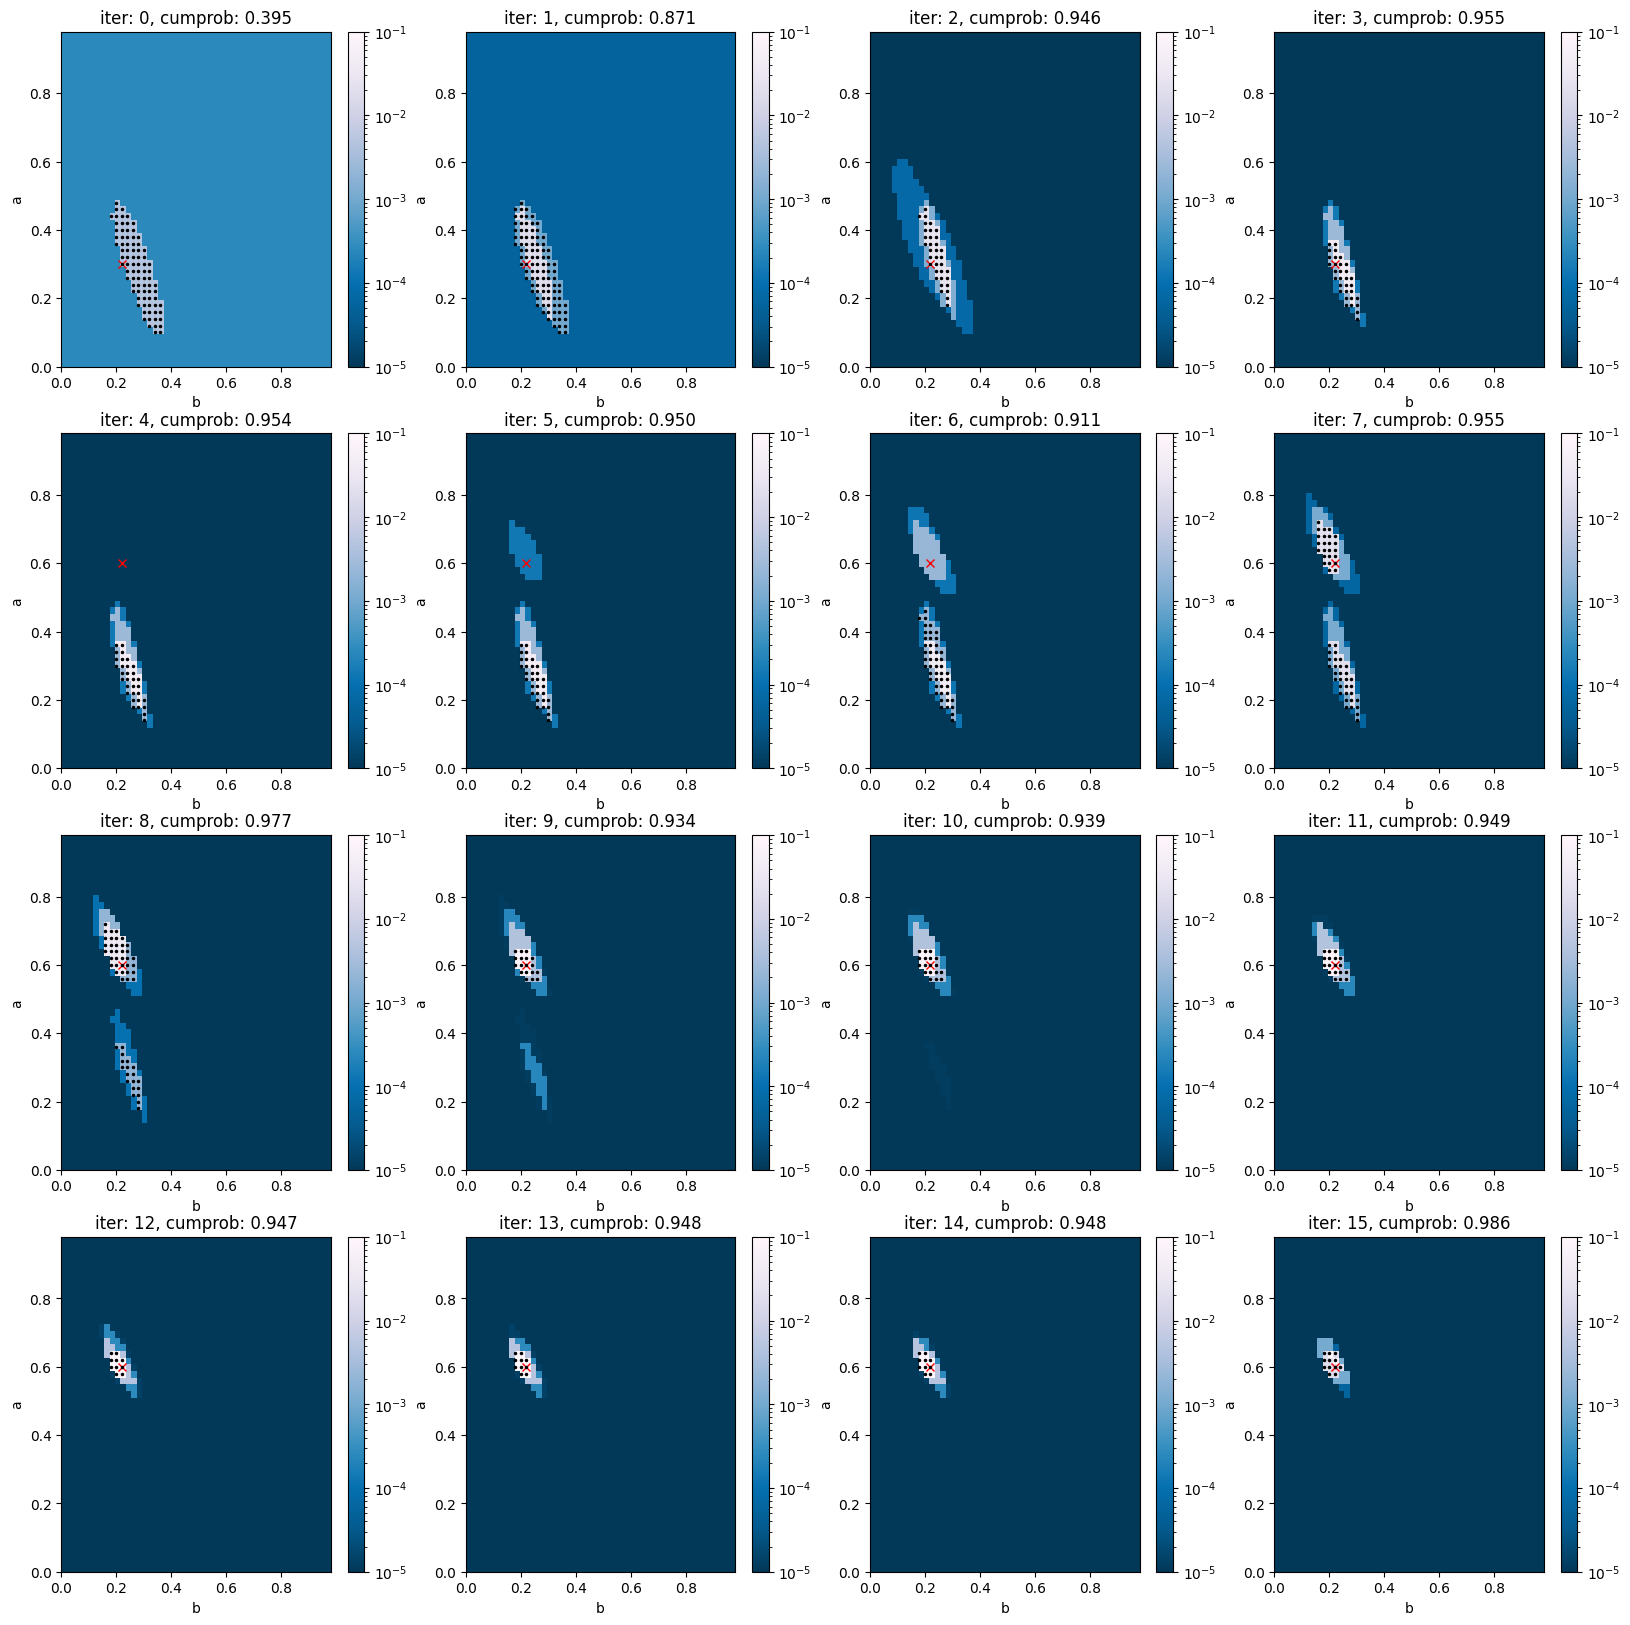

In [34]:
# set up the grid of plots
n_plots = n_iters
n_cols = 4
n_rows = int(cp.ceil(n_plots / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
axes = axes.flatten()

# plot the fused confidence region from each SPS run, as well as the points sampled from it
for idx in range(n_plots):
    plot_fused_conf_region(posterior_vals[idx], fig, axes[idx], a_values, b_values, title=f"iter: {idx}, cumprob: {p_vals[idx]:.3f}")
    plot_results(sampled_conf_region_vals[idx], a_vals[idx], 0.22, fig, axes[idx])

#### Simple 3x3 fusion

In [35]:
# # ~~~~~~~~~~ simple 3x3 fusion

# results_vals = [cp.array([[0.6,0.2],[0.5,0.2],[0.6,0.3]]),
#                 cp.array([[0.5,0.2],[0.5,0.3],[0.6,0.3]])]

# a_range = cp.arange(0.5, 0.8, 0.1)
# b_range = cp.arange(0.1, 0.4, 0.1)

# a_grid, b_grid = cp.meshgrid(a_range, b_range, indexing='ij')

# prior = cp.ones((3,3)) * 0.05
# new_info = cp.ones((3,3)) * 0.05
# epsilon = 1e-6
# for i in range(3):
#     for j in range(3):
#         a = a_grid[i][j]
#         b = b_grid[i][j]
        
#         # Check if the current gridpoint (a, b) is in the confidence region, update prior
#         if cp.any(cp.all(cp.isclose(results_vals[0], cp.array([a, b]), atol=epsilon), axis=1)):
#             prior[i][j] = 0.95
#             # print(a,b)

#         if cp.any(cp.all(cp.isclose(results_vals[1], cp.array([a, b]), atol=epsilon), axis=1)):
#             new_info[i][j] = 0.95
#             # print("posterior",a,b)

# prior /= cp.sum(cp.abs(prior))
# posterior = cp.multiply(prior,new_info)
# posterior /= cp.sum(cp.abs(posterior))

# plt.figure()
# plt.imshow(prior, cmap="Greens", origin="lower", extent=[b_range[0] - 0.05, b_range[-1]- 0.05, a_range[0]- 0.05, a_range[-1]- 0.05])
# plt.xticks(b_range)
# plt.yticks(a_range)
# plt.colorbar()
# plt.show()

# plt.figure()
# plt.imshow(new_info, cmap="Greens", origin="lower", extent=[b_range[0] - 0.05, b_range[-1]- 0.05, a_range[0]- 0.05, a_range[-1]- 0.05])
# plt.xticks(b_range)
# plt.yticks(a_range)
# plt.colorbar()
# plt.show()

# plt.figure()
# plt.imshow(posterior, cmap="Greens", origin="lower", extent=[b_range[0] - 0.05, b_range[-1]- 0.05, a_range[0]- 0.05, a_range[-1]- 0.05])
# plt.xticks(b_range)
# plt.yticks(a_range)
# plt.colorbar()
# plt.show()